Clone repositories we will be using and install the requirements.

In [ ]:
%tensorflow_version 1.x

!git clone https://github.com/NVIDIA/tacotron2
!sed -i 's/from distributed import/from tacotron2.distributed import/g' "/content/tacotron2/train.py"
!pip install -q librosa unidecode

TensorFlow 1.x selected.
Cloning into 'tacotron2'...
remote: Enumerating objects: 406, done.
remote: Total 406 (delta 0), reused 0 (delta 0), pack-reused 406
Receiving objects: 100% (406/406), 2.69 MiB | 28.15 MiB/s, done.
Resolving deltas: 100% (205/205), done.
     |████████████████████████████████| 245kB 9.0MB/s 


In [ ]:
import sys

sys.path.append('tacotron2/')

# Tacotron2 + Griffin-Lim

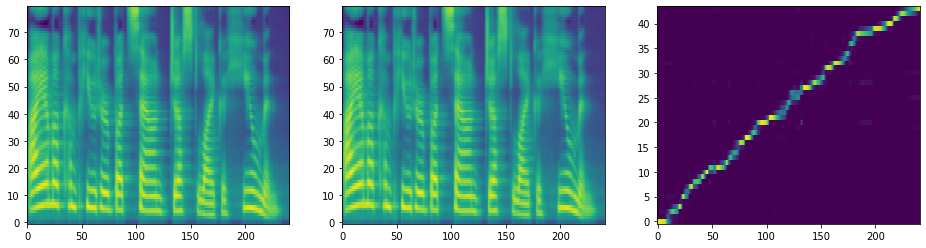

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

hparams = create_hparams()
hparams.sampling_rate = 22050

checkpoint_path = "/content/drive/MyDrive/gt_pretrained_models/tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

text = "I am a computer but sound just like a human."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

taco_stft = TacotronSTFT(
    hparams.filter_length, hparams.hop_length, hparams.win_length, 
    sampling_rate=hparams.sampling_rate)
mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet)
mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
spec_from_mel_scaling = 1000
spec_from_mel = torch.mm(mel_decompress[0].float(), taco_stft.mel_basis)
spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
spec_from_mel = spec_from_mel * spec_from_mel_scaling

waveform = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), 
                       taco_stft.stft_fn, 50)

ipd.Audio(waveform[0].data.cpu().numpy(), rate=hparams.sampling_rate)